In [1]:
import glob
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np
import os
import cv2

tf.config.set_visible_devices([], "GPU")
sm.set_framework("tf.keras")
sm.framework()

tf.random.set_seed(1024)

2021-11-23 13:52:37.823677: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


2021-11-23 13:52:40.068581: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-23 13:52:40.260517: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-23 13:52:40.260565: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


# Data cleaning process


In [2]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    image = tf.image.decode_image(image)

    [
        label,
    ] = tf.py_function(get_mask, [label], [tf.float32])

    return image, label


def path_2(path):

    [output1, output2] = tf.py_function(
        lambda x: (
            f"images/{x.numpy().decode('utf-8')}.jpg",
            f"images/{x.numpy().decode('utf-8')}.txt",
        ),
        [path],
        [tf.string, tf.string],
    )

    return (output1, output2)


def get_mask(filepath):
    blackimg = np.zeros([1080, 1920], np.int32)
    with open(filepath.numpy().decode("utf-8"), "r") as f:
        for i in f.readlines():
            classncoor = [float(x) for x in i.replace("\n", "").split(" ")]
            x = int(classncoor[1:][0] * 1920)
            y = int(classncoor[1:][1] * 1080)
            width = int(classncoor[1:][2] * 1920)
            height = int(classncoor[1:][3] * 1080)

            halfwidth = width // 2
            halfheight = height // 2

            blackimg = cv2.rectangle(
                blackimg,
                [x - halfwidth, y - halfheight],
                [x + halfwidth, y + halfheight],
                (1),
                -1,
            )

    whiteimg = blackimg <= 127
    blackimg = blackimg
    whiteimg = whiteimg
    whiteimg = np.reshape(whiteimg, [1080, 1920, 1])
    blackimg = np.reshape(blackimg, [1080, 1920, 1])

    return np.concatenate([whiteimg, blackimg], -1)


# [w, h, c], 360, 360, 3
def decode_crop(image, label):
    label = tf.cast(label, tf.float32)

    padding_left = 64
    padding_right = 64
    padding_top = 92
    padding_bottom = 92

    # padding
    image = image[padding_top:-padding_bottom, padding_left:-padding_right, :]
    label = label[padding_top:-padding_bottom, padding_left:-padding_right, :]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[224 * x : 224 * (1 + x), 224 * y : 224 * (1 + y)])
        label_array.append(label[224 * x : 224 * (1 + x), 224 * y : 224 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def create_ds(batch_size, ratio=0.8):
    AUTOTUNE = tf.data.AUTOTUNE

    paths = [x.split(".")[0] for x in os.listdir("images") if x.find(".jpg") != -1]
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(path_2, AUTOTUNE)

    ds = ds.cache()

    # get train and test ratio
    takefortrain = int(160 * ratio)
    trainds = ds.take(takefortrain)
    testds = ds.skip(takefortrain).take(160 - takefortrain)

    # shuffle
    trainds = trainds.shuffle(160)

    trainds = trainds.map(get_image_decode, AUTOTUNE)
    testds = testds.map(get_image_decode, AUTOTUNE)

    # break fullhd into chuck
    # trainds = trainds.flat_map(decode_crop)
    # testds = testds.flat_map(decode_crop)

    # # batch and prefetch
    trainds = trainds.batch(batch_size)
    testds = testds.batch(batch_size)

    trainds = trainds.prefetch(AUTOTUNE)

    return trainds, testds


# trainds, testds = create_ds(1)

# for i, y in trainds.take(10):
#     fig, axs = plt.subplots(1, 3, figsize=(16, 9))
#     axs[0].imshow(i[0])
#     axs[2].imshow(
#         i[0] * tf.cast(tf.repeat(y[0, ..., 1][..., tf.newaxis], 3, -1), tf.uint8)
#     )
#     axs[1].imshow(y[0, ..., 1])

#     fig.savefig('abc.png', dpi=300)

In [3]:
def create_backbone():
    _backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=[None, None, 3]
    )

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


class FPN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone()
        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_bn = tf.keras.layers.BatchNormalization()
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_bn = tf.keras.layers.BatchNormalization()
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_bn = tf.keras.layers.BatchNormalization()
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_bn = tf.keras.layers.BatchNormalization()
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=training)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)
        conv5_p = self.conv5_bn(conv5_p, training=training)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)
        conv4_p = self.conv4_bn(conv4_p, training=training)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)
        conv3_p = self.conv3_bn(conv3_p, training=training)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)
        conv2_p = self.conv2_bn(conv2_p, training=training)
        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN()
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.bnorm = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.bnorm(m_all, training=training)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


In [4]:
# the network must OUTPUT in logits [-inf, inf]
# make sure input dimension is [B, H, W, C]
def Jindex(target, pred):
    intersection = tf.reduce_sum(target * pred, [0, 1, 2])
    union = tf.reduce_sum(target + pred, [0, 1, 2]) - intersection
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))


def Dice(target, pred):
    intersection = tf.reduce_sum(2 * pred * target, [0, 1, 2])
    union = tf.reduce_sum(pred + target, [0, 1, 2])
    return tf.reduce_mean((intersection + 0.1) / (union + 0.1))

In [5]:
# this iteration is calculated fom 160 iteration from
# paper
n_epoch = 20
n_classes = 2
batch_size = 1
trainds, testds = create_ds(batch_size)
model = FCN(n_classes)

2021-11-23 13:52:40.481073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
optimizer = tf.keras.optimizers.Adam(1e-5)
focal_loss = sm.losses.CategoricalFocalLoss()
dice_loss = sm.losses.DiceLoss(class_weights=[0.001, 0.999])

In [7]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, "trained_model/fcn2", 5)
ckptmg.restore_or_initialize()

'trained_model/fcn2/ckpt-132'

In [8]:
# sum_jindex = 0
# sum_loss = 0
# count = 0
# for img, lbl in testds:
#     pred = model(img, training=False)

#     sum_jindex += Jindex(lbl, pred)
#     sum_loss += focal_loss(lbl, pred) + dice_loss(lbl, pred)
#     count += 1

# print(f"IoU: {sum_jindex / count}")
# print(f"Loss: {sum_loss / count}")

In [9]:
def draw_boundingbox(img, mask):
    thres = mask[0, ..., 1] > 0.5
    thres = thres.numpy() * 255
    thres = thres.astype(np.uint8)
    contours, heirarchy = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    plt.figure(figsize=(16, 9))
    image = img.numpy()
    # drawing bounding box
    for i in contours:
        [x, y, width, height] = cv2.boundingRect(i)
        img = cv2.rectangle(image, [x, y], [x + width, y + height], (0, 255, 0), -1)
    plt.imshow(image)

(1, 896, 1792, 3)
tf.Tensor(0.741256, shape=(), dtype=float32)
(1, 896, 1792, 3)
tf.Tensor(0.5536239, shape=(), dtype=float32)
(1, 896, 1792, 3)
tf.Tensor(0.63099754, shape=(), dtype=float32)
(1, 896, 1792, 3)
tf.Tensor(0.79364944, shape=(), dtype=float32)
(1, 896, 1792, 3)
tf.Tensor(0.5941808, shape=(), dtype=float32)


2021-11-23 13:56:28.854156: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


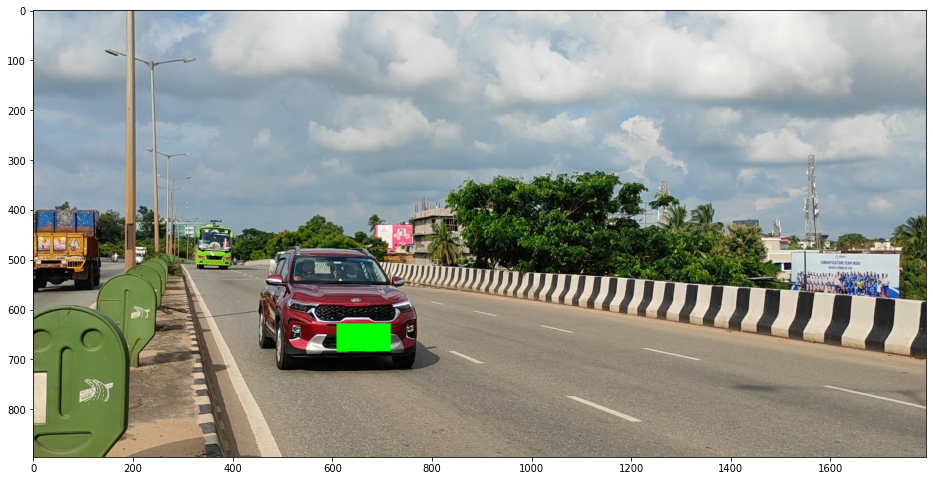

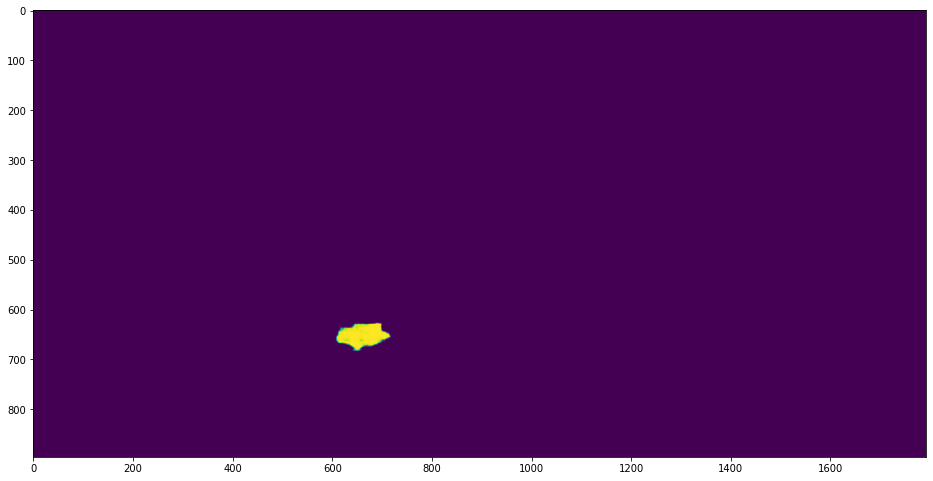

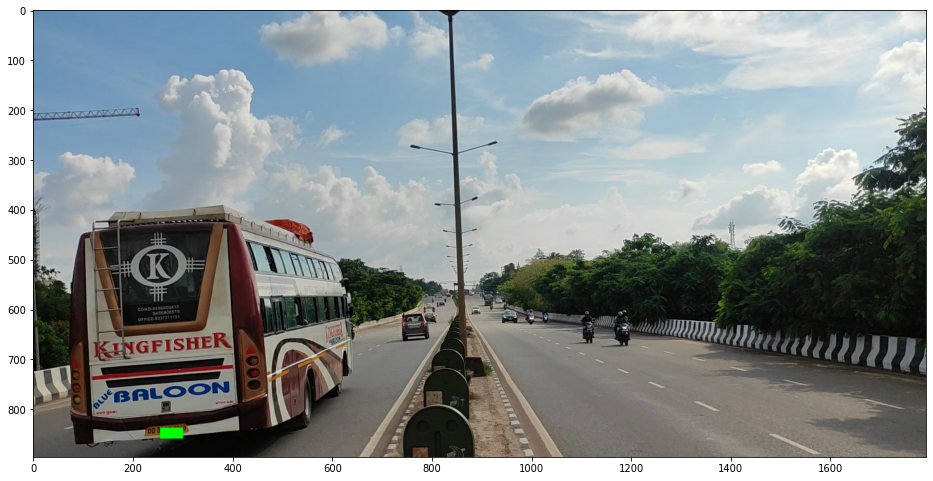

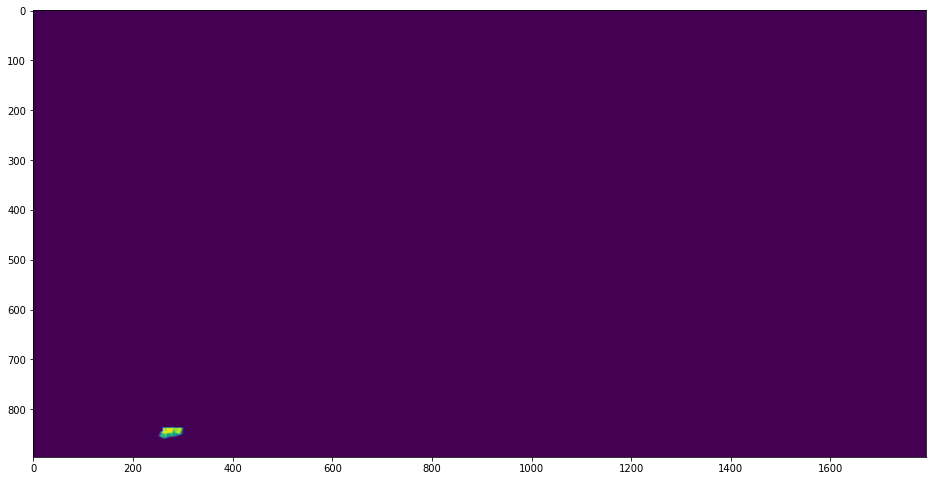

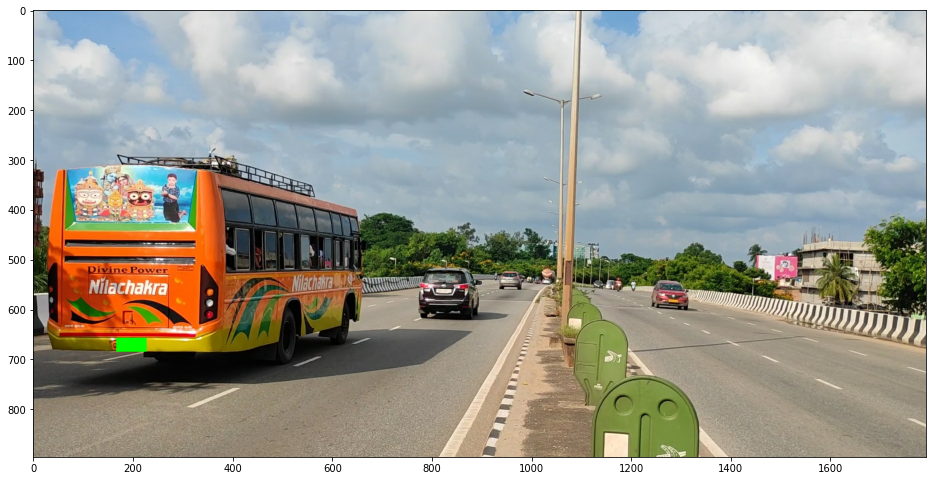

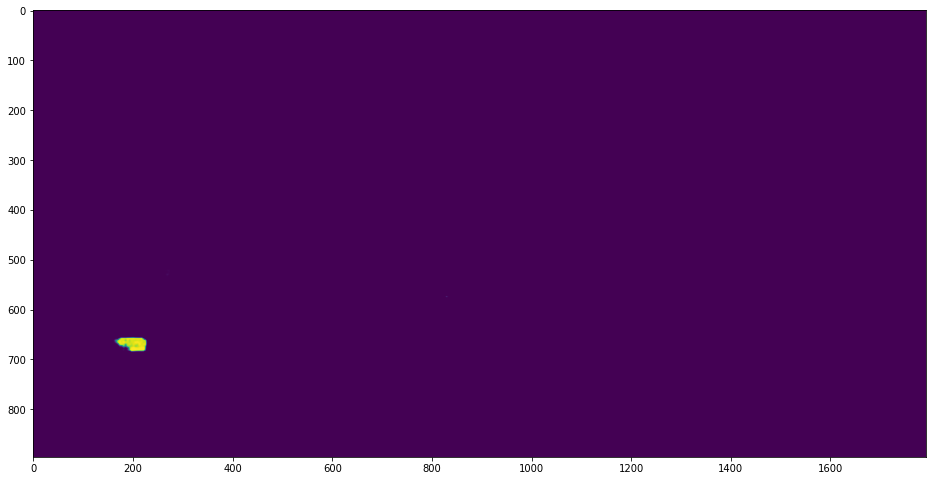

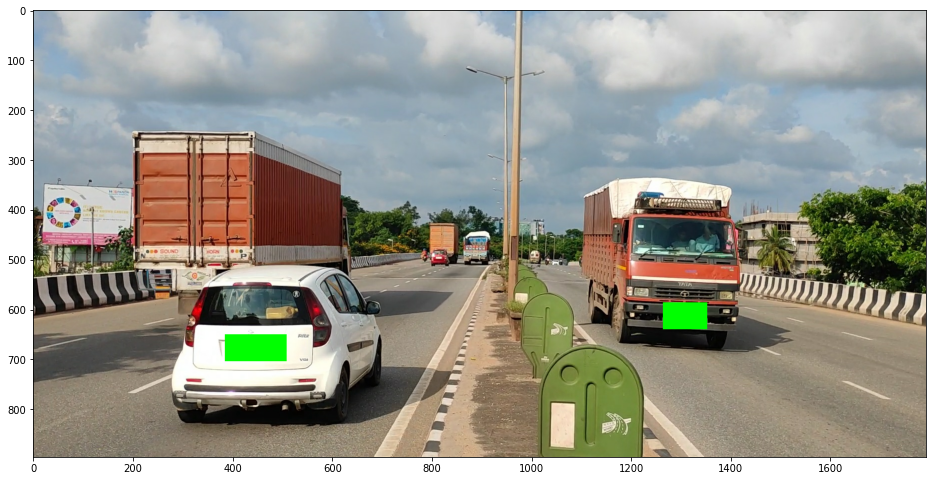

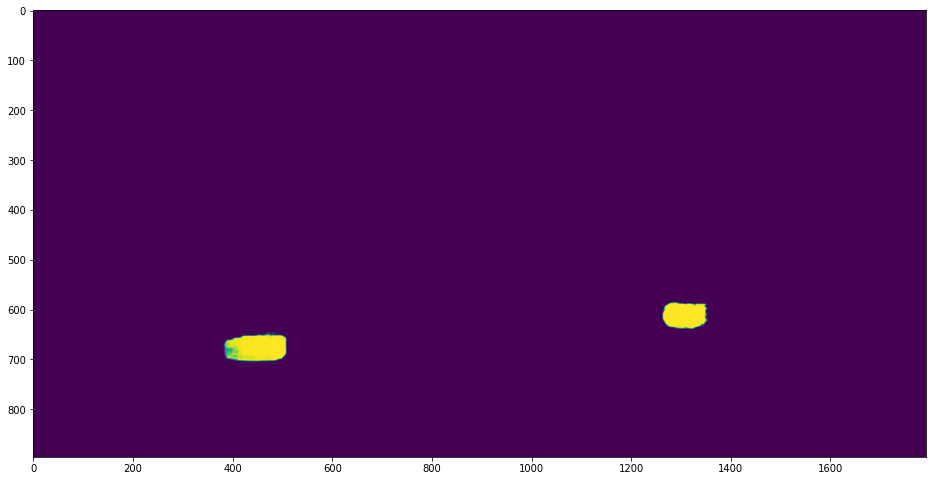

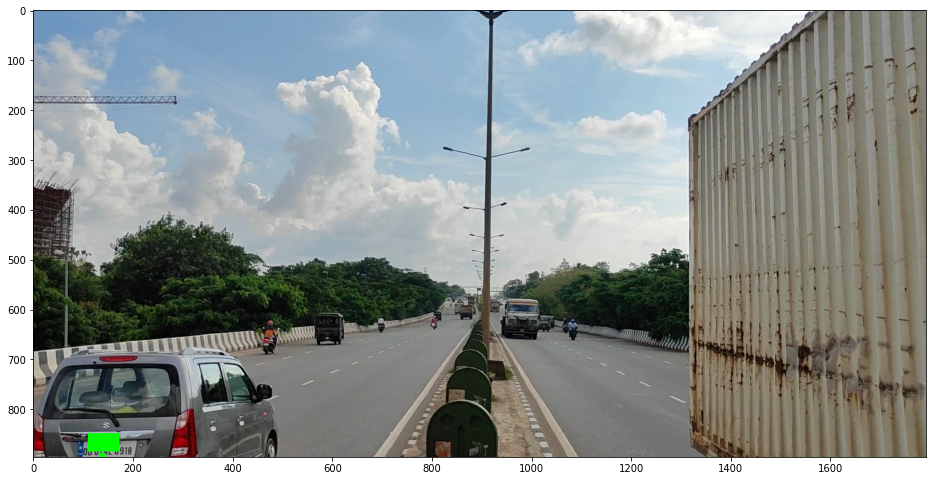

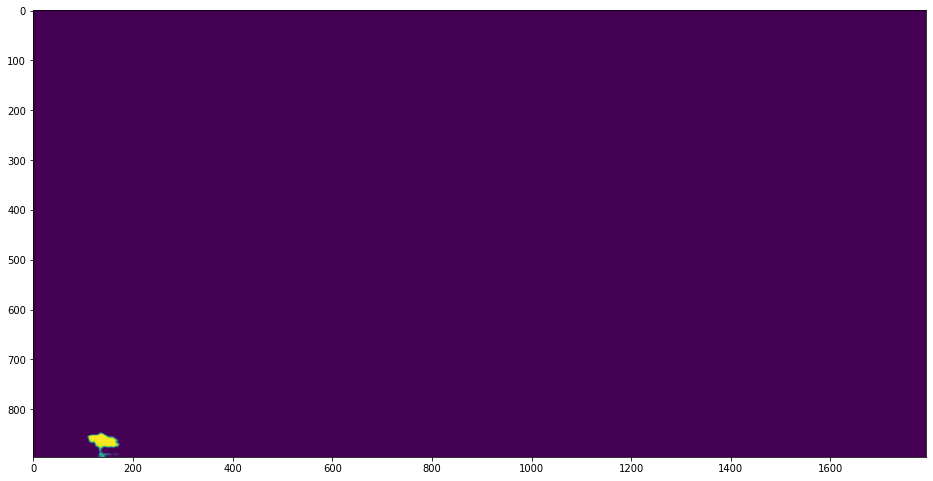

In [12]:
padding_left = 64
padding_right = 64
padding_top = 92
padding_bottom = 92

for img, lbl in testds.skip(5).take(5):
    img = img[..., padding_top:-padding_bottom, padding_left:-padding_right, :]
    lbl = lbl[..., padding_top:-padding_bottom, padding_left:-padding_right, :]
    print(img.shape)

    pred = model(img, training=False)
    draw_boundingbox(img[0], pred)
    print(sm.metrics.iou_score(lbl, pred))
    plt.figure(figsize=(16, 9))
    plt.imshow(pred[0, ..., 1])

# Notes
The networks shows high generalization capacity at low epoch while the area of intersection is low.
After 120 epochs, network shows overfitting to train dataset but high area of intersection.